# Recommender System for Goodbooks‑10K  
**Rating Prediction & Top‑K Recommendation**

---

## 1. Data Processing

### 1.1 Imports & Settings
```python

In [7]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
# for evaluation
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Load Book

In [8]:
books   = pd.read_csv('../Data/books.csv')
ratings = pd.read_csv('../Data/ratings.csv')
print(f"Books:   {books.shape}")
print(f"Ratings: {ratings.shape}")

Books:   (10000, 23)
Ratings: (981756, 3)


Quick EDA

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


rating
1     19575
2     63231
3    248623
4    357366
5    292961
Name: count, dtype: int64


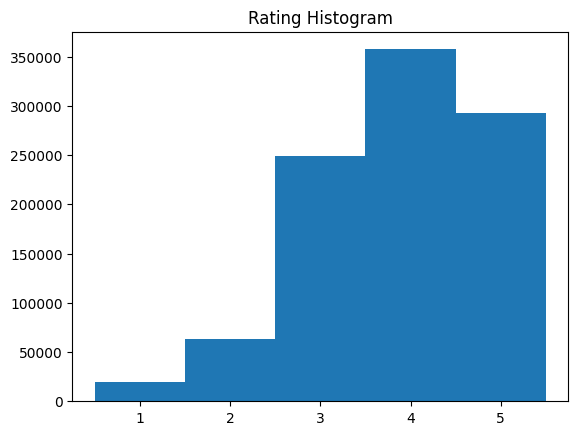

Ratings per user: count    53424.000000
mean        18.376685
std         26.268690
min          2.000000
25%          3.000000
50%          8.000000
75%         22.000000
max        200.000000
Name: count, dtype: float64
Ratings per book: count    10000.000000
mean        98.175600
std          5.690167
min          8.000000
25%         99.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: count, dtype: float64


In [9]:
# Preview
display(books.head())
display(ratings.head())

# Rating distribution
print(ratings['rating'].value_counts().sort_index())
plt.hist(ratings['rating'], bins=np.arange(1,7)-0.5); plt.title('Rating Histogram'); plt.show()

# Activity per user / book
print("Ratings per user:", ratings['user_id'].value_counts().describe())
print("Ratings per book:", ratings['book_id'].value_counts().describe())


Filter & Re‑index

In [10]:
# Filter out users/books with <5 ratings
min_u, min_i = 5, 5
u_counts = ratings['user_id'].value_counts()
i_counts = ratings['book_id'].value_counts()
ratings = ratings[ratings['user_id'].isin(u_counts[u_counts>=min_u].index)
                  & ratings['book_id'].isin(i_counts[i_counts>=min_i].index)]

# Map to 0…N−1
user_map = {u:idx for idx,u in enumerate(ratings['user_id'].unique())}
book_map = {i:idx for idx,i in enumerate(ratings['book_id'].unique())}
ratings['uidx'] = ratings['user_id'].map(user_map)
ratings['iidx'] = ratings['book_id'].map(book_map)

n_users, n_items = len(user_map), len(book_map)
print("After filtering:", n_users, "users &", n_items, "books")


After filtering: 35710 users & 10000 books


Train/Test Split & Sparse Matrix

In [11]:
train_df, test_df = train_test_split(
    ratings[['uidx','iidx','rating']],
    test_size=0.2, random_state=42
)

train_mat = csr_matrix(
    (train_df['rating'], (train_df['uidx'], train_df['iidx'])),
    shape=(n_users, n_items)
)


Approach 1: User‑Based Collaborative Filtering

In [12]:
from sklearn.metrics.pairwise import pairwise_distances

# -- 1) Compute full-length user_means array --
# initialize with zeros
user_means = np.zeros(n_users, dtype=float)

# compute means only for users in train_df
grp = train_df.groupby('uidx')['rating'].mean()
user_means[grp.index.values] = grp.values

# (If any user had zero training ratings, user_means will stay 0.)

# -- 2) Convert to dense (for centering) & subtract means --
train_dense = train_mat.toarray().astype(float)     # shape (n_users, n_items)
train_centered = train_dense - user_means[:, None]  # now shapes match

# -- 3) Compute Pearson similarity via cosine on centered data --
#    Pearson(u,v) = cosine( (r_u - mean_u), (r_v - mean_v) )
user_sim = 1 - pairwise_distances(train_centered, metric='cosine')
np.fill_diagonal(user_sim, 0)  # zero out self-similarity


Predict Function

In [13]:
def predict_ubcf(u, i, k=20):
    sims = user_sim[u]
    # find top-k similar users who rated i
    rated = train_mat[:,i].nonzero()[0]
    candidates = [(v, sims[v]) for v in rated]
    topk = sorted(candidates, key=lambda x: -abs(x[1]))[:k]
    num = sum(sim*(train_mat[v,i]-user_means[v]) for v,sim in topk)
    den = sum(abs(sim) for _,sim in topk)
    return user_means[u] + (num/den if den>0 else 0)

# Vectorize for full matrix prediction if desired...


Evaluate Rating Prediction (RMSE)

In [15]:
preds = [predict_ubcf(u,i) for u,i,r in zip(test_df.uidx, test_df.iidx, test_df.rating)]
rmse_ubcf = mean_squared_error(test_df.rating, preds)
print("UBCF RMSE:", rmse_ubcf)


UBCF RMSE: 0.730211047149951


In [16]:
def top_k_recs(u, k=10):
    scores = [predict_ubcf(u,i) for i in range(n_items)]
    seen = set(train_df[train_df.uidx==u].iidx)
    unseen_scores = [(i,s) for i,s in enumerate(scores) if i not in seen]
    return [i for i,_ in sorted(unseen_scores, key=lambda x:-x[1])[:k]]

# Compute Precision@10 for a random sample of users
# (You’ll need to define functions for precision@k using test_df as ground truth.)


Approach 2: Matrix Factorization (ALS or SVD)
Using implicit’s ALS

In [18]:
import implicit

# implicit expects item‑user matrix
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=15)
als_model.fit(train_mat.T * 15)   # confidence weighting

# Predict single rating: dot(U[u], V[i])
user_vecs = als_model.user_factors
item_vecs = als_model.item_factors

b:\BHT Study\SEM 2\Data Science WorkflowApplications\Project\venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
b:\BHT Study\SEM 2\Data Science WorkflowApplications\Project\venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.011302471160888672 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [21]:
valid_users = set(range(user_vecs.shape[0]))
valid_items = set(range(item_vecs.shape[0]))

# Filter test set to known users and items
filtered_test_df = test_df[
    test_df['uidx'].isin(valid_users) & test_df['iidx'].isin(valid_items)
]


In [22]:
preds_mf = [predict_mf(u, i) for u, i in zip(filtered_test_df.uidx, filtered_test_df.iidx)]

# Use RMSE (or root_mean_squared_error)
from sklearn.metrics import root_mean_squared_error
rmse_mf = root_mean_squared_error(filtered_test_df.rating, preds_mf)
print("MF RMSE:", rmse_mf)


MF RMSE: 3.825174069819084


In [23]:
def top_k_mf(u, k=10):
    scores = item_vecs.dot(user_vecs[u])
    seen = set(train_df[train_df.uidx==u].iidx)
    unseen = [(i,s) for i,s in enumerate(scores) if i not in seen]
    return [i for i,_ in sorted(unseen, key=lambda x:-x[1])[:k]]


In [24]:
print(f"UBCF RMSE = {rmse_ubcf:.4f}")
print(f"MF   RMSE = {rmse_mf:.4f}")


UBCF RMSE = 0.7302
MF   RMSE = 3.8252
